# Time Series Analysis with Recurrent Nueral Networks (Keras)

1. Get Data
2. Explore Data
3. Clean and prepare data
4. Split into training and testing sets
5. Assemble Model
6. Train Model
7. Evaluate Model
8. Profit?

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4458659987430360639
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6661821563
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8144120182066136055
physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:07:00.0, compute capability: 6.1"
]


## 1. Get Data

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import math

df = pd.read_csv('../Historical Data/SPY.csv')
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6937.000000,6937.000000,6937.000000,6937.000000,6937.000000,6.937000e+03
mean,140.802595,141.638252,139.874313,140.802893,116.212247,8.476343e+07
std,67.454442,67.731955,67.149970,67.465521,72.581787,9.729696e+07
min,43.343750,43.531250,42.812500,43.406250,25.867437,5.200000e+03
25%,99.019997,99.849998,98.019997,99.040001,71.149460,7.600200e+06
50%,126.699997,127.389999,125.720001,126.610001,93.763985,5.793120e+07
75%,169.789993,170.179993,169.050003,169.690002,148.173859,1.217750e+08
max,337.790009,339.079987,337.480011,338.339996,337.440002,8.710263e+08


In [4]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6937 entries, 0 to 6936
Data columns (total 7 columns):
Date         6937 non-null object
Open         6937 non-null float64
High         6937 non-null float64
Low          6937 non-null float64
Close        6937 non-null float64
Adj Close    6937 non-null float64
Volume       6937 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 379.5+ KB


In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,26.184059,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,26.370279,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,26.426161,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.705482,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.817228,531500


In [7]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
6932,2020-08-10,335.059998,335.769989,332.959991,335.570007,335.570007,44282100
6933,2020-08-11,336.850006,337.540009,332.010010,332.799988,332.799988,69601100
6934,2020-08-12,335.440002,338.279999,335.410004,337.440002,337.440002,53826100
6935,2020-08-13,336.609985,338.250000,335.829987,336.829987,336.829987,41816100
6936,2020-08-14,336.410004,337.420013,335.619995,336.839996,336.839996,47238800


## 2. Explore Data

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


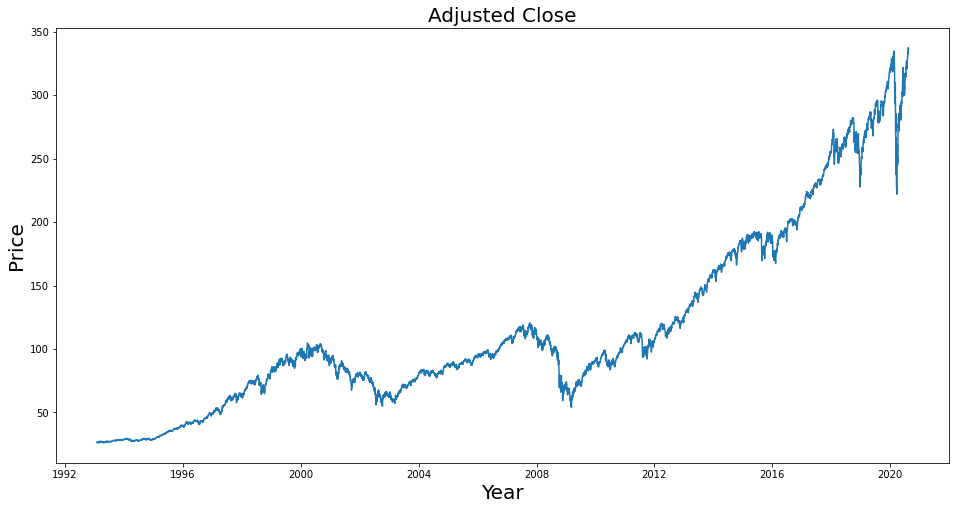

In [8]:
df['Date'] = pd.to_datetime(df['Date']) 
x = df.Date
Y = df['Adj Close']

plt.figure(figsize=[16,8])
plt.plot(x,Y)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.title('Adjusted Close',fontsize=20)
plt.show()


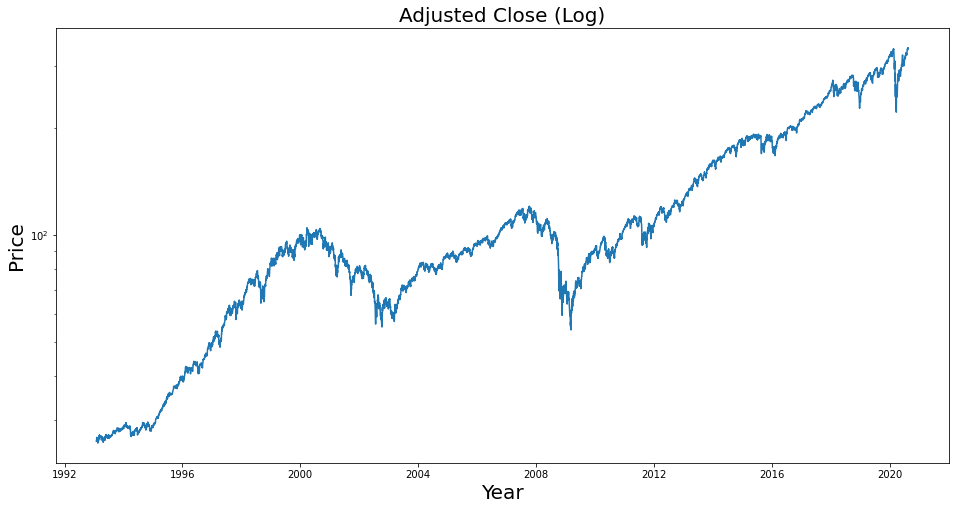

In [9]:
plt.figure(figsize=[16,8])
plt.plot(x,Y)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.title('Adjusted Close (Log)',fontsize=20)
plt.yscale('log')
plt.show()

In [10]:
df['Adj High'] = (df['Adj Close']/df['Close'])*df['High']
df['Adj Low'] = (df['Adj Close']/df['Close'])*df['Low']
df['Adj Volume'] = df['Volume']

data=df[['Adj Close','Adj Volume','Adj High','Adj Low']]
data.head()

,Adj Close,Adj Volume,Adj High,Adj Low
0,26.184059,1003200,26.202682,26.072320
1,26.370279,480500,26.370279,26.202671
2,26.426161,201300,26.444784,26.295799
3,26.705482,529400,26.724105,26.444759
4,26.817228,531500,26.873097,26.500636


## 3. Clean and Prepare Data

In [11]:
dataCopy = data.copy()

data.loc[:,('dailyReturn')] = np.log(dataCopy.loc[:,('Adj Close')]/dataCopy.loc[:,('Adj Close')].shift(1))
data.loc[:,'weeklyReturn'] = np.log(dataCopy.loc[:,'Adj Close']/dataCopy.loc[:,'Adj Close'].shift(5))
data.loc[:,'dailyHL'] = np.log(dataCopy.loc[:,'Adj High']/dataCopy['Adj Low'])
data.loc[:,'weeklyHL'] = np.log(dataCopy.loc[:,'Adj High'].rolling(6).max()/dataCopy.loc[:,'Adj Low'].rolling(6).min())
data.head(12)

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Adj Close,Adj Volume,Adj High,Adj Low,dailyReturn,weeklyReturn,dailyHL,weeklyHL
0,26.184059,1003200,26.202682,26.072320,NaN,NaN,0.004988,NaN
1,26.370279,480500,26.370279,26.202671,0.007087,NaN,0.006376,NaN
2,26.426161,201300,26.444784,26.295799,0.002117,NaN,0.005650,NaN
3,26.705482,529400,26.724105,26.444759,0.010514,NaN,0.010508,NaN
4,26.817228,531500,26.873097,26.500636,0.004176,NaN,0.013957,NaN
5,26.798601,492100,26.854470,26.649616,-0.000695,0.023199,0.007658,0.030251
6,26.798601,596100,26.891716,26.761355,0.000000,0.016112,0.004859,0.025957
7,26.612383,122100,26.705498,26.556514,-0.006973,0.007022,0.005594,0.022409
8,26.649626,379600,26.668249,26.537888,0.001398,-0.002094,0.004900,0.016760
9,26.779993,19500,26.891731,26.686878,0.004880,-0.001389,0.007647,0.014650


In [12]:
data = data.dropna(how='any')
data.head()

,Adj Close,Adj Volume,Adj High,Adj Low,dailyReturn,weeklyReturn,dailyHL,weeklyHL
5,26.798601,492100,26.854470,26.649616,-0.000695,0.023199,0.007658,0.030251
6,26.798601,596100,26.891716,26.761355,0.000000,0.016112,0.004859,0.025957
7,26.612383,122100,26.705498,26.556514,-0.006973,0.007022,0.005594,0.022409
8,26.649626,379600,26.668249,26.537888,0.001398,-0.002094,0.004900,0.016760
9,26.779993,19500,26.891731,26.686878,0.004880,-0.001389,0.007647,0.014650


In [13]:
def toTimeSeries(df,columns,n_trail=1,n_lead=1):
    df = df[columns]
    n_columns=len(columns)
    cols=[]
    names=[]
    
    # Create trailing columns
    for i in range(n_trail,0,-1):
        cols.append(df.shift(i))
        names += [(columns[j]+'(t-%d)'%(i))  for j in range(n_columns)]
        
    # Create leading columns
    for i in range(0,n_lead+1):
        cols.append(df.shift(-i))
        names += [(columns[j]+'(t+%d)'%(i))  for j in range(n_columns)]
        
    agg = pd.concat(cols,axis=1)
    agg.columns = names
    
    # Clean up NaN rows
    agg.dropna(inplace=True)
    
    return agg

In [14]:
n_trail = 5
n_lead = 5
columns = ['dailyReturn','weeklyReturn','dailyHL','weeklyHL']

reframed = toTimeSeries(data,columns,n_trail,n_lead)
print(reframed.head())

    dailyReturn(t-5)  weeklyReturn(t-5)  dailyHL(t-5)  weeklyHL(t-5)  \
10         -0.000695           0.023199      0.007658       0.030251   
11          0.000000           0.016112      0.004859       0.025957   
12         -0.006973           0.007022      0.005594       0.022409   
13          0.001398          -0.002094      0.004900       0.016760   
14          0.004880          -0.001389      0.007647       0.014650   

    dailyReturn(t-4)  weeklyReturn(t-4)  dailyHL(t-4)  weeklyHL(t-4)  \
10          0.000000           0.016112      0.004859       0.025957   
11         -0.006973           0.007022      0.005594       0.022409   
12          0.001398          -0.002094      0.004900       0.016760   
13          0.004880          -0.001389      0.007647       0.014650   
14         -0.007679          -0.008374      0.006287       0.013245   

    dailyReturn(t-3)  weeklyReturn(t-3)  ...  dailyHL(t+3)  weeklyHL(t+3)  \
10         -0.006973           0.007022  ...      0.02593

## 4. Split in Training and Testing Data

In [15]:
values = reframed.values

trainTestSplit = 0.75

mask = np.random.rand(len(values)) < trainTestSplit

train = values[mask,:]
test = values[~mask,:]
print(train.shape)

# Number of features
n_columns = len(columns)
n_features = (n_lead - 1) * n_columns
n_periods = n_trail + 1

# Number of periods in observation
n_obs = n_periods * n_columns

# Assign test and training sets
X_train, Y_train = train[:,0:n_obs], train[:,-n_features:]
print(X_train.shape)
X_train = X_train.reshape((X_train.shape[0], n_periods, n_columns))

X_test, Y_test = test[:,0:n_obs], test[:,-n_features:]
X_test = X_test.reshape((X_test.shape[0], n_periods, n_columns))
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

new_train = []
for i, train in enumerate(Y_train):
    new_train.append(Y_train[i][-n_columns:].tolist())
Y_train = np.array(new_train)

new_test = []
for i, test in enumerate(Y_test):
    new_test.append(Y_test[i][-n_columns:].tolist())
Y_test = np.array(new_test)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(5204, 44)
(5204, 24)
(5204, 6, 4) (5204, 16) (1718, 6, 4) (1718, 16)
(5204, 6, 4) (5204, 4) (1718, 6, 4) (1718, 4)


## 5. Assemble the Model

In [16]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

with tf.device('/GPU:0'):
    model = Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1:])))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(len(columns)))
    model.compile(loss='mae',optimizer='Adam')

Using TensorFlow backend.


Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0

In [17]:
print(model.summary())
model.get_config()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 50)             11000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 50)             20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 204       
Total params: 51,604
Trainable params: 51,604
Non-trainable params: 0
_________________________________________________________________
None


{'name': 'sequential_1',
 'layers': [{'class_name': 'LSTM',
   'config': {'name': 'lstm_1',
    'trainable': True,
    'batch_input_shape': (None, 6, 4),
    'dtype': 'float32',
    'return_sequences': True,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'units': 50,
    'activation': 'tanh',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'unit_forget_bias': True,
    'kernel_regularizer': None,
    'recurrent_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'recurrent_constraint': None,
    'bias_constraint': None,

## 6. Train the Model

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Train on 5204 samples, validate on 1718 samples
Epoch 1/50
Executing op __inference_keras_scratch_graph_3622 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_keras_scratch_graph_3926 in 

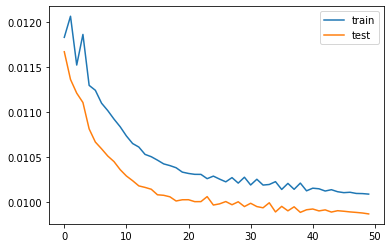

In [18]:
# fit network
history = model.fit(X_train, Y_train, epochs=50, batch_size=72, validation_data=(X_test, Y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 7. Evaluate the Model

In [19]:
Y_predicted = model.predict(X_test)
results = pd.DataFrame(Y_test)
col1, col2, col3, col4 = [],[],[],[]

for pred in Y_predicted:
    col1.append(pred[0])
    col2.append(pred[1])
    col3.append(pred[2])
    col4.append(pred[3])

results[2], results[3], results[4], results[5] = col1, col2, col3, col4
results.columns = ['Daily Return','Weekly Return','Predicted Daily', 'Predicted Weekly', 
                   'Daily HL', 'Weekly HL']
results.head()

Executing op __inference_keras_scratch_graph_23614 in device /job:localhost/replica:0/task:0/device:GPU:0


,Daily Return,Weekly Return,Predicted Daily,Predicted Weekly,Daily HL,Weekly HL
0,-0.000716,0.005020,0.003501,0.010621,0.010309,0.034696
1,0.012793,0.018533,0.002690,0.007399,0.008703,0.031656
2,0.001408,0.019184,0.002217,0.007007,0.010758,0.035346
3,-0.002820,0.012783,0.001871,0.006024,0.011746,0.034638
4,-0.005555,0.011909,0.001658,0.004955,0.011053,0.030218


In [20]:
results['Prop'] = results['Weekly Return']/results['Predicted Weekly']

results['Correct'] = results['Prop'].apply(lambda x : 1 if x > 0.5 and x < 2 else 0)
results['Correct2'] = (results['Weekly Return']*results['Predicted Weekly']).apply(lambda x : 1 if x > 0 else 0)

print('Direction and Magnitude Accuracy Score: ', results.Correct.sum()/results.Correct.count())
print('Direction Only Accuracy Score: ', results.Correct2.sum()/results.Correct2.count())

Direction and Magnitude Accuracy Score:  0.20838183934807916
Direction Only Accuracy Score:  0.580908032596042


In [21]:
np.corrcoef(results['Weekly Return'], results['Predicted Weekly'])

array([[1.        , 0.04507969],
       [0.04507969, 1.        ]])

In [22]:
results['Risk-Reward'] = results['Predicted Weekly']/results['Weekly HL']
analyze = results.copy(deep=True)

buySignal = analyze['Risk-Reward'].quantile(0.95)
sellSignal = analyze['Risk-Reward'].quantile(0.05)

print('Buy Signal: ', buySignal)
print('Sell Signal: ', sellSignal)

Buy Signal:  0.2677090612575156
Sell Signal:  0.1398504212754685


In [23]:
analyze = analyze[(analyze['Risk-Reward'] > buySignal) | (analyze['Risk-Reward'] <= sellSignal)]
print('Trade Signal x% of the time: ', analyze.shape[0]/results.shape[0])
analyze.head()

Trade Signal x% of the time:  0.10011641443538999


,Daily Return,Weekly Return,Predicted Daily,Predicted Weekly,Daily HL,Weekly HL,Prop,Correct,Correct2,Risk-Reward
0,-0.000716,0.005020,0.003501,0.010621,0.010309,0.034696,0.472601,0,1,0.306123
15,0.004274,0.000711,0.002860,0.008113,0.009256,0.029199,0.087640,0,1,0.277840
30,-0.000696,0.015428,0.002808,0.007866,0.009022,0.027956,1.961350,1,1,0.281372
36,0.001391,0.002783,0.002261,0.005352,0.007126,0.019364,0.520065,1,1,0.276369
38,0.000000,0.015824,0.002302,0.005281,0.006922,0.018625,2.996456,0,1,0.283531


In [24]:
import sklearn
from sklearn.linear_model import LinearRegression

X = analyze['Risk-Reward']
Y = analyze['Weekly Return']

X = np.array(X).reshape(len(X),1)
Y = np.array(Y).reshape(len(Y),1)

lr = LinearRegression()
lr = lr.fit(X,Y)
preds = lr.predict(X)

from sklearn.metrics import r2_score

print('R^2 Score: ', r2_score(Y,preds))

R^2 Score:  0.005891548832828941


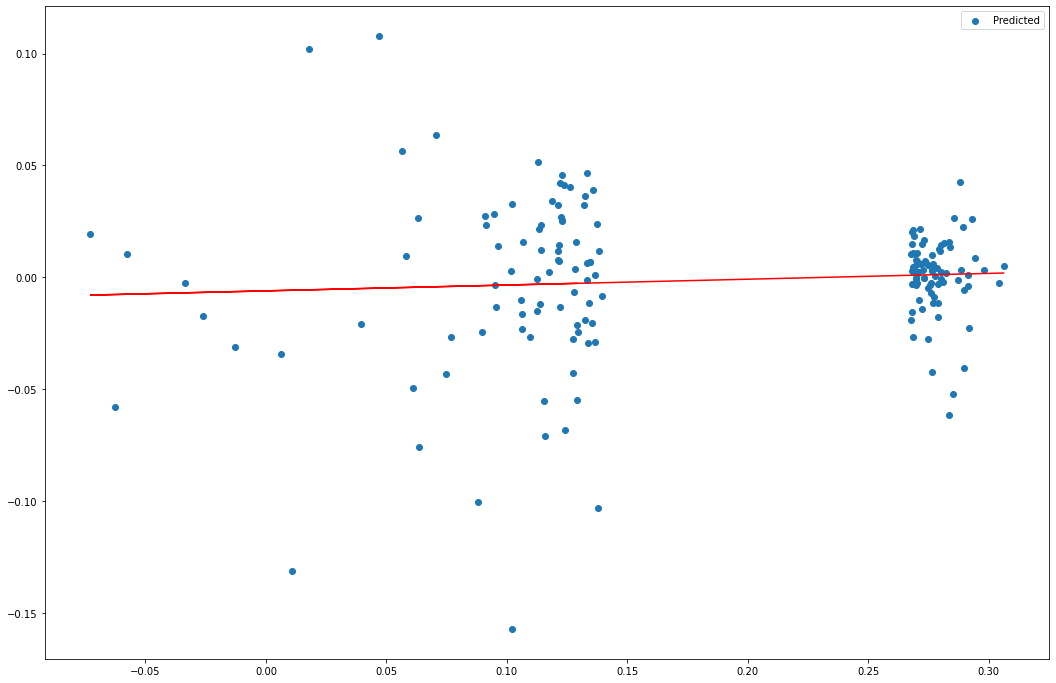

In [25]:
plt.figure(figsize=(18,12))
time = list(range(0,len(X)))
plt.scatter(X,Y,label='Predicted')
plt.plot(X,preds,color='r')
plt.legend()
plt.show()

## 8. Profit?

In [26]:
portfolio = [1000]
hodl = [1000]
bpFee = 20
feeModifier = 1 - (bpFee / 10000)

predicted = results['Predicted Weekly'].tolist()
actual = results['Weekly Return'].tolist()
riskReward = results['Risk-Reward'].tolist()

for prediction in riskReward:
    idx = riskReward.index(prediction)
    if prediction > buySignal:
        today = np.exp(actual[idx])*(portfolio[-1]*feeModifier)
    elif prediction < sellSignal:
        today = np.exp(-actual[idx])*(portfolio[-1]*feeModifier)
    else:
        today = portfolio[-1]
    portfolio.append(today)
    
    hodl.append(np.exp(actual[idx])*hodl[-1])
    
print('Annualized Return: ', ((((portfolio[-1]-1000)/1000)+1)**(52/len(portfolio))-1)*100,'%')

Annualized Return:  -0.05264084724632134 %


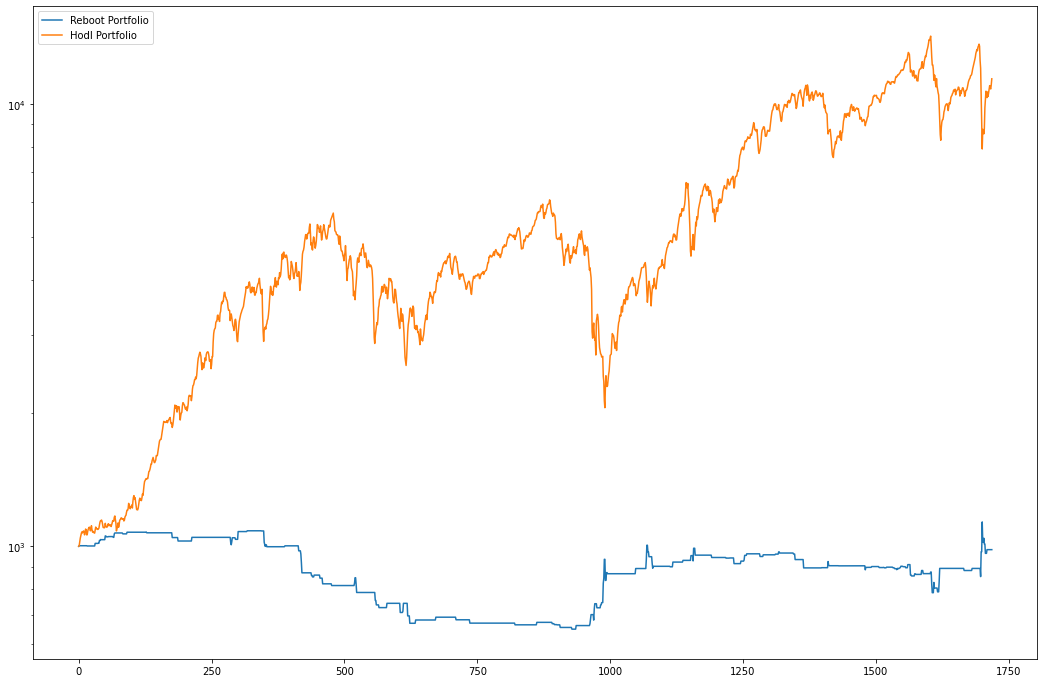

In [27]:
plt.figure(figsize=(18,12))
time = list(range(0,len(portfolio)))
plt.plot(time,portfolio,label='Reboot Portfolio')
plt.plot(time,hodl,label='Hodl Portfolio')
plt.legend()
plt.yscale('log')
plt.show()

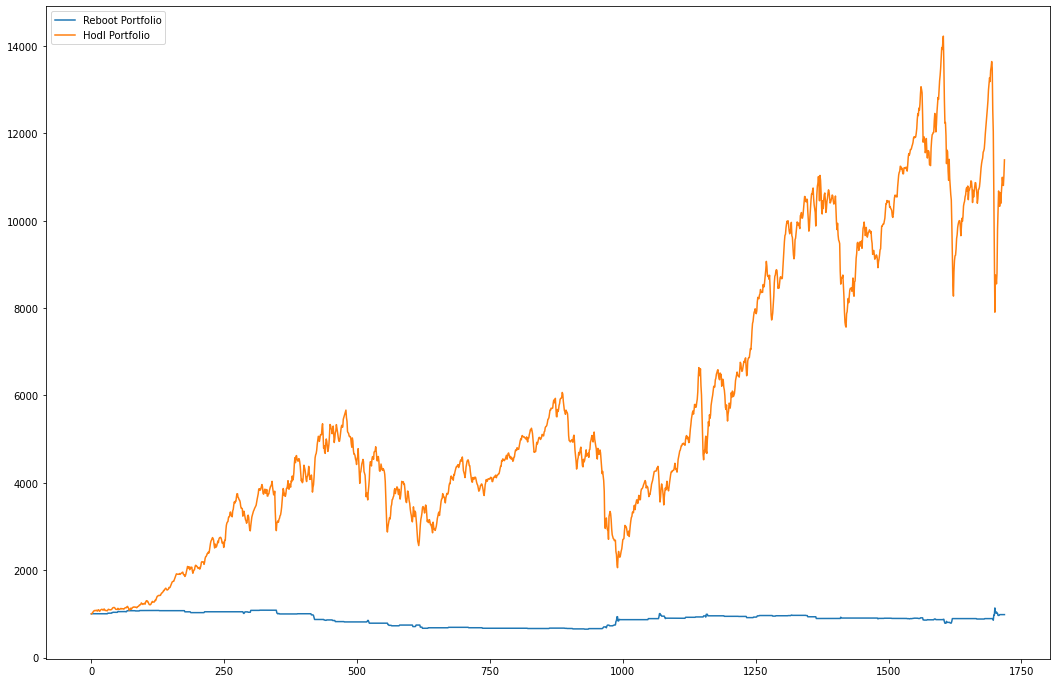

In [28]:
plt.figure(figsize=(18,12))
time = list(range(0,len(portfolio)))
plt.plot(time,portfolio,label='Reboot Portfolio')
plt.plot(time,hodl,label='Hodl Portfolio')
plt.legend()
plt.show()

In [29]:
port_df = pd.DataFrame(portfolio,index=time,columns=['portfolio'])
port_df['hodl'] = hodl
port_df['symbol'] = 'SPY'
date_list = df[::4].head(port_df.shape[0]).Date.tolist()
port_df['Date'] = date_list
port_df = port_df[['Date','portfolio','hodl','symbol']]
port_df.to_csv('../Results Data/SPY_results.csv',index=False)
port_df

,Date,portfolio,hodl,symbol
0,1993-01-29,1000.000000,1000.000000,SPY
1,1993-02-04,1003.022227,1005.032291,SPY
2,1993-02-10,1003.022227,1023.831732,SPY
3,1993-02-17,1003.022227,1043.662596,SPY
4,1993-02-23,1003.022227,1057.089841,SPY
...,...,...,...,...
1714,2020-04-22,982.744186,10997.175421,SPY
1715,2020-04-28,982.744186,10867.243667,SPY
1716,2020-05-04,982.744186,10809.393528,SPY
1717,2020-05-08,982.744186,11041.792501,SPY


In [30]:
port_df

,Date,portfolio,hodl,symbol
0,1993-01-29,1000.000000,1000.000000,SPY
1,1993-02-04,1003.022227,1005.032291,SPY
2,1993-02-10,1003.022227,1023.831732,SPY
3,1993-02-17,1003.022227,1043.662596,SPY
4,1993-02-23,1003.022227,1057.089841,SPY
...,...,...,...,...
1714,2020-04-22,982.744186,10997.175421,SPY
1715,2020-04-28,982.744186,10867.243667,SPY
1716,2020-05-04,982.744186,10809.393528,SPY
1717,2020-05-08,982.744186,11041.792501,SPY


In [31]:
df[::4]

,Date,Open,High,Low,Close,Adj Close,Volume,Adj High,Adj Low,Adj Volume
0,1993-01-29,43.968750,43.968750,43.750000,43.937500,26.184059,1003200,26.202682,26.072320,1003200
4,1993-02-04,44.968750,45.093750,44.468750,45.000000,26.817228,531500,26.873097,26.500636,531500
8,1993-02-10,44.656250,44.750000,44.531250,44.718750,26.649626,379600,26.668249,26.537888,379600
12,1993-02-17,43.468750,43.531250,43.281250,43.437500,25.886072,210900,25.941941,25.792957,210900
16,1993-02-23,43.843750,43.875000,43.468750,43.687500,26.035061,373700,26.146799,25.904699,373700
...,...,...,...,...,...,...,...,...,...,...
6920,2020-07-23,326.470001,327.230011,321.480011,322.959991,322.959991,75738000,327.230011,321.480011,75738000
6924,2020-07-29,322.119995,325.730011,322.079987,325.119995,325.119995,48454200,325.730011,322.079987,48454200
6928,2020-08-04,327.859985,330.059998,327.859985,330.059998,330.059998,41917900,330.059998,327.859985,41917900
6932,2020-08-10,335.059998,335.769989,332.959991,335.570007,335.570007,44282100,335.769989,332.959991,44282100
